In [1]:
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [71]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, \
        f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv("./text/clean_compiled_transcripts.csv")

CV = CountVectorizer(min_df=3) # ignore terms that appear in less than 3 documents

X_t = CV.fit_transform(df.Transcript).toarray()
y_t = df.PHQ_Binary.to_numpy()

RANDOM_STATE = 42 # lucky number

X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_t, y_t, test_size=0.2, random_state=RANDOM_STATE)
X_train_t.shape, X_test_t.shape

((144, 2877), (37, 2877))

In [22]:
df = pd.read_csv("./gaze/gaze_labels.csv", index_col = "Participant_ID")
X_g = np.load("./gaze/avg_gaze.npy")
y_g = np.array(df['PHQ_Binary'])

X_train_g, X_test_g, y_train_g, y_test_g = train_test_split(X_g, y_g, test_size=0.2, random_state=RANDOM_STATE)
X_train_g.shape, X_test_g.shape

((144, 14), (37, 14))

In [66]:
def evaluate_on_training_set(y_test, y_pred):
    # Calculate AUC
    print("AUC is: ", roc_auc_score(y_test, y_pred))

    # print out recall and precision
    print(classification_report(y_test, y_pred))

    # print out confusion matrix
    print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))

    # # calculate points for ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)

    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc_score(y_test, y_pred))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')

In [82]:
class Ensemble:
    def __init__(self):
        self.clf = []
        self.X_train = []
        self.X_test = []
        self.y_train = None
        self.y_test = None
        
    def set_clf(self, ls_clf):
        self.clf = ls_clf
    
    def set_train_test(self, ls_train, ls_test, y_train, y_test):
        self.X_train = ls_train
        self.X_test = ls_test
        self.y_train = y_train
        self.y_test = y_test
        
    def train_ens(self):
        for i in range(len(self.clf)):
            c_i = self.clf[i]
            X_train_i = self.X_train[i]
            y_train = self.y_train
            c_i.fit(X_train_i, y_train)
            self.clf[i] = c_i
    
    def pred_proba(self, ls_X):
        probas = []
        for i in range(len(self.clf)):
            c_i = self.clf[i]
            probas.append(c_i.predict_proba(ls_X[i]))
        probas = np.array(probas)
        probas = np.mean(probas, axis=0)
        return probas
    
    def pred_ens(self, ls_X):
        probas = self.pred_proba(ls_X)
        label = np.argmax(probas)
        return label
    
    def evaluate_ens(self):
        predictions = []       
        for i in range(len(self.y_test)):
            ls_X = []
            for j in range(len(self.clf)):
                ls_X.append(self.X_test[j][i:i+1][:])
            predictions.append(e.pred_ens(ls_X))
        predictions = np.array(predictions)
        print(self.y_test)
        print(predictions)
        evaluate_on_training_set(self.y_test, predictions)
        

In [91]:
e = Ensemble()
clf1 = LogisticRegression(n_jobs=3, C=10**3)
# clf2 = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=2, min_samples_leaf=16)
clf3 = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=1, min_samples_leaf=8)
clfs = [clf1, clf3]
e.set_clf(clfs)
e.set_train_test([X_train_t, X_train_g], [X_test_t, X_test_g], y_train_t, y_test_t)

In [92]:
e.train_ens()

[1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 0]
[0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1]
AUC is:  0.6503496503496504
              precision    recall  f1-score   support

           0       0.79      0.85      0.81        26
           1       0.56      0.45      0.50        11

    accuracy                           0.73        37
   macro avg       0.67      0.65      0.66        37
weighted avg       0.72      0.73      0.72        37

Confusion Matrix: 
 [[22  4]
 [ 6  5]]


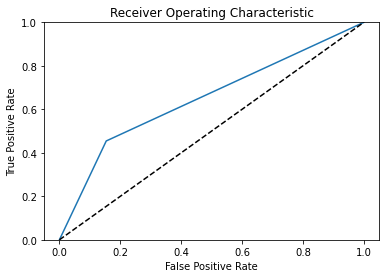

In [93]:
e.evaluate_ens()